In [6]:
import pandas as pd
import numpy as np
import dill

import matplotlib.pyplot as plt

In [7]:
def gen_gaussian():
    r = [2*(np.random.random()-0.5) for i in range(7)]
    
    a = 1*r[0]
    b = 1*r[1]
    c = 1*r[2]
    s = 10*(np.random.random()-0.6)
    
    def ax1(x,y):
        return a*x + b*y + c

    def ax2(x,y):
        return e*x + d*y + f
    
    def gaussian(x,y):
        return s*np.exp(-(ax1(x,y)**2))
    
    def gradient(x,y):
        return np.array([
            -2*(a*ax1(x,y))*gaussian(x,y),
            -2*(b*ax1(x,y))*gaussian(x,y)
        ])

    def hessian(x,y):
        return np.array([[
            (-2*(a**2) + 4*(a*ax1(x,y))**2)*gaussian(x,y),
            (-2*(a*b) + 4*(a*ax1(x,y))*(b*ax1(x,y)))*gaussian(x,y)
        ],
        [
            (-2*(a*b) + 4*(a*ax1(x,y))*(b*ax1(x,y)))*gaussian(x,y),
            (-2*(b**2) + 4*(b*ax1(x,y))**2)*gaussian(x,y),
        ]])

    return (gaussian, gradient, hessian)

In [8]:
def gen_exp_loss_landscape(n=10):
    gaussians = [gen_gaussian() for i in range(n)]
    
    def loss(p):
        s = np.exp(sum([g[0](*p)**2 + g[1](*p)**2 for g in gaussians]))
        return s

    return loss

In [9]:
def gen_loss_landscape(n=10):
    gaussians = [gen_gaussian() for i in range(n)]
    
    def loss(p):
        s = sum([g[0](*p) for g in gaussians])
        return s
    
    def gradient(p):
        s = np.sum(np.array([g[1](*p) for g in gaussians]), axis=0)
        return s
        
    def hessian(p):
        s = np.sum(np.array([g[2](*p) for g in gaussians]), axis=0)
        return s

    return (loss, gradient, hessian)

In [10]:
#L, G, H = gen_loss_landscape()
with open("func.dill", "rb") as f:
    L, G, H = dill.load(f)

In [11]:
v_L = np.vectorize(L, signature='(2)->()')

In [12]:
x = np.linspace(-10,10,201)
y = np.linspace(-10,10,201)
P = np.meshgrid(x, y)
z = np.stack(P, axis=2)

In [13]:
ll = v_L(z)

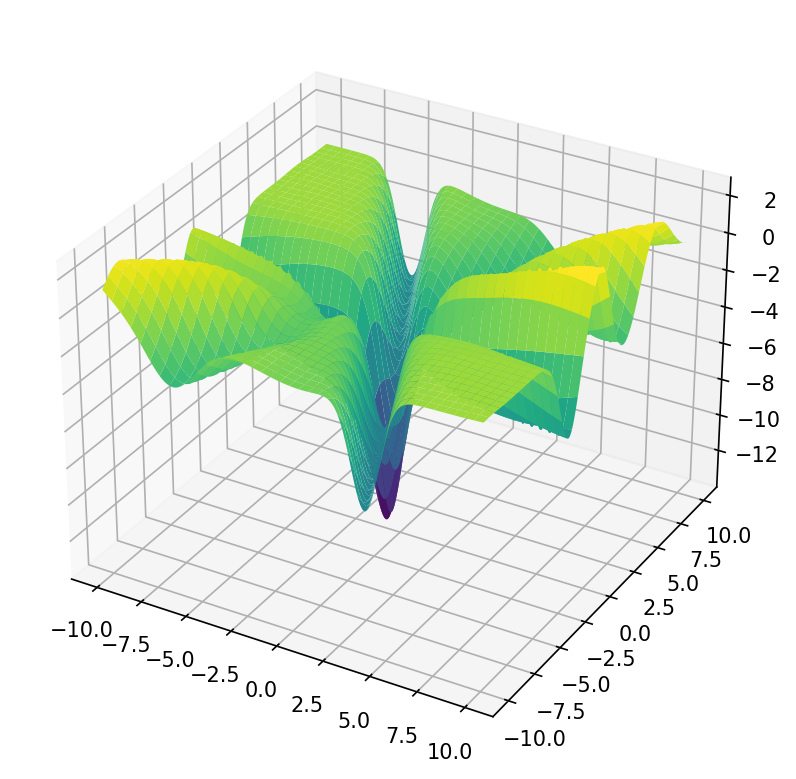

In [14]:
fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_axes([0,0,1,1], projection='3d')
surf = ax.plot_surface(P[0], P[1], ll, cmap='viridis', edgecolor=None, alpha=1)
# ax.set_xlabel('theta_0')
# ax.set_ylabel('theta_1')
# ax.set_zlabel('loss')
fig.savefig('loss_fn.png')

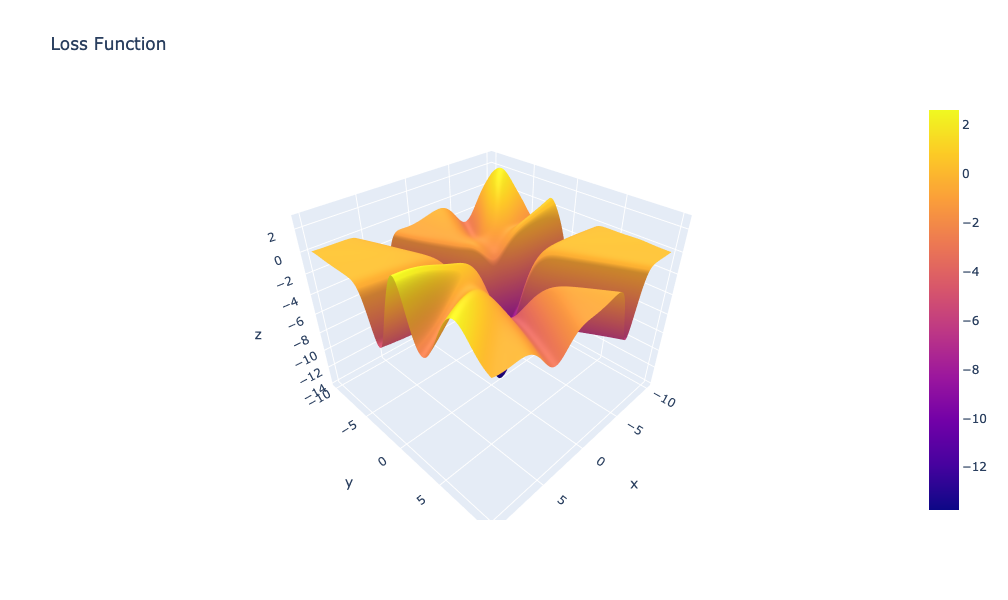

In [19]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#xp, yp = np.array(data['Adam'][0]).T
contour = go.Surface(
    z = ll,
    x = x,
    y = y
)

fig = make_subplots()
fig.add_trace(contour)
#fig.add_trace(path)
fig['layout'].update(height = 600, width = 800, title = "Loss Function")
fig.show()
fig.write_html("loss_fn_interactive.html")

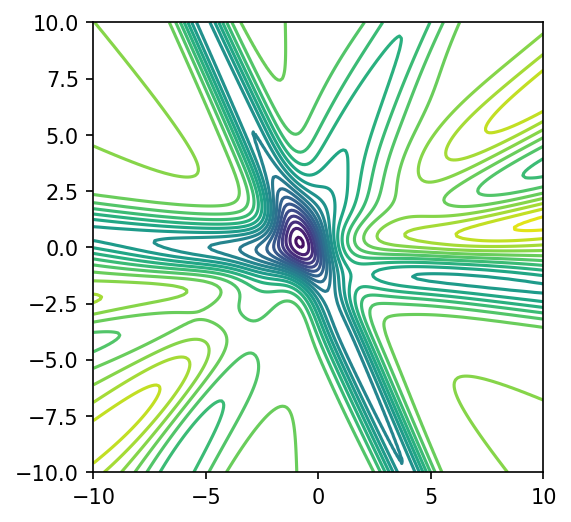

In [10]:
fig = plt.figure(figsize=(3,3), dpi=150)
ax = fig.add_axes([0,0,1,1])
CS = plt.contour(x, y, ll, 20)

In [11]:
from numpy.linalg import norm

def SGD(L, G, p0, eps=1e-2):
    # stopping criterion? - 500 steps should be ok for now I guess
    p = p0
    path = [p]
    velocity = []
    g = np.inf
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        p = p - eps*g
        path.append(p)
        velocity.append(norm(eps*g))
    
    return path, velocity

def SGD_momentum(L, G, p0, v0=0, eps=1e-2, a=0.9):
    
    p = p0
    v = v0
    path = [p]
    velocity = []
    g = np.inf
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        v = a*v - eps*g
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def SGD_nesterov(L, G, p0, v0=0, eps=1e-2, a=0.9):
    
    p = p0
    v = v0
    path = [p]
    velocity = []
    g = np.inf
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p + a*v)
        v = a*v - eps*g # nesterov update
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def AdaGrad(L, G, p0, eps=1e-2):
    
    r = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        r = r + g**2
        v = - ((eps)/np.sqrt(r))*g
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def RMSProp(L, G, p0, eps=1e-2, decay=0.9):
    
    r = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        r = decay*r + (1-decay)*g**2
        v = - ((eps)/np.sqrt(r+1e-7))*g
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def RMSProp_nesterov(L, G, p0, eps=1e-2, decay=0.9, a=0.9):
    
    r = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p + a*v)
        r = decay*r + (1-decay)*g**2
        v = a*v - ((eps)/np.sqrt(r+1e-7))*g
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def Adam(L, G, p0, eps=1e-3, b1=0.9, b2=0.999):
    
    r = np.zeros(2)
    s = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    t = 0
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        t += 1
        s = b1*s + (1-b1)*g
        r = b2*r + (1-b2)*g**2
        sh = s/(1-b1**t)
        rh = r/(1-b2**t)
        v = - ((eps)/np.sqrt(rh+1e-7))*sh
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def NAdam(L, G, p0, eps=1e-3, b1=0.9, b2=0.999):
    
    r = np.zeros(2)
    s = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    t = 0
    while norm(g) > 5e-2 and len(path) < 1000:
        g = G(p)
        t += 1
        s = b1*s + (1-b1)*g
        r = b2*r + (1-b2)*g**2
        sh = b1*s/(1-b1**t) + (1-b1)*g/(1-b1**t) # nesterov update for next sequence
        rh = r/(1-b2**t)
        v = - ((eps)/np.sqrt(rh+1e-7))*sh
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

# Not really an 'optimization' algorithm, more like a regularization algorithm
def AdamW(L, G, p0, eps=1e-3, b1=0.9, b2=0.999, l=1):
    
    r = np.zeros(2)
    s = np.zeros(2)
    p = p0
    v = 0
    path = [p]
    g = np.inf
    velocity = []
    t = 0
    while norm(g) > 5e-2 and t < 1000:
        g = G(p)
        t += 1
        s = b1*s + (1-b1)*g
        r = b2*r + (1-b2)*g**2
        sh = s/(1-b1**t)
        rh = r/(1-b2**t)
        v = - ( ((eps)/np.sqrt(rh+1e-7))*sh + l*p ) # adamW step
        p = p + v
        path.append(p)
        velocity.append(norm(v))
    
    return path, velocity

def Newton(L, G, H, p0):
    p = p0
    path = [p]
    g = np.inf
    velocity = []
    while norm(g) > 5e-2:
        g = G(p)
        h = H(p)
        v = -g@np.linalg.inv(h).T
        p = p + v
        path.append(p)
        velocity.append(norm(p))

    return path, velocity

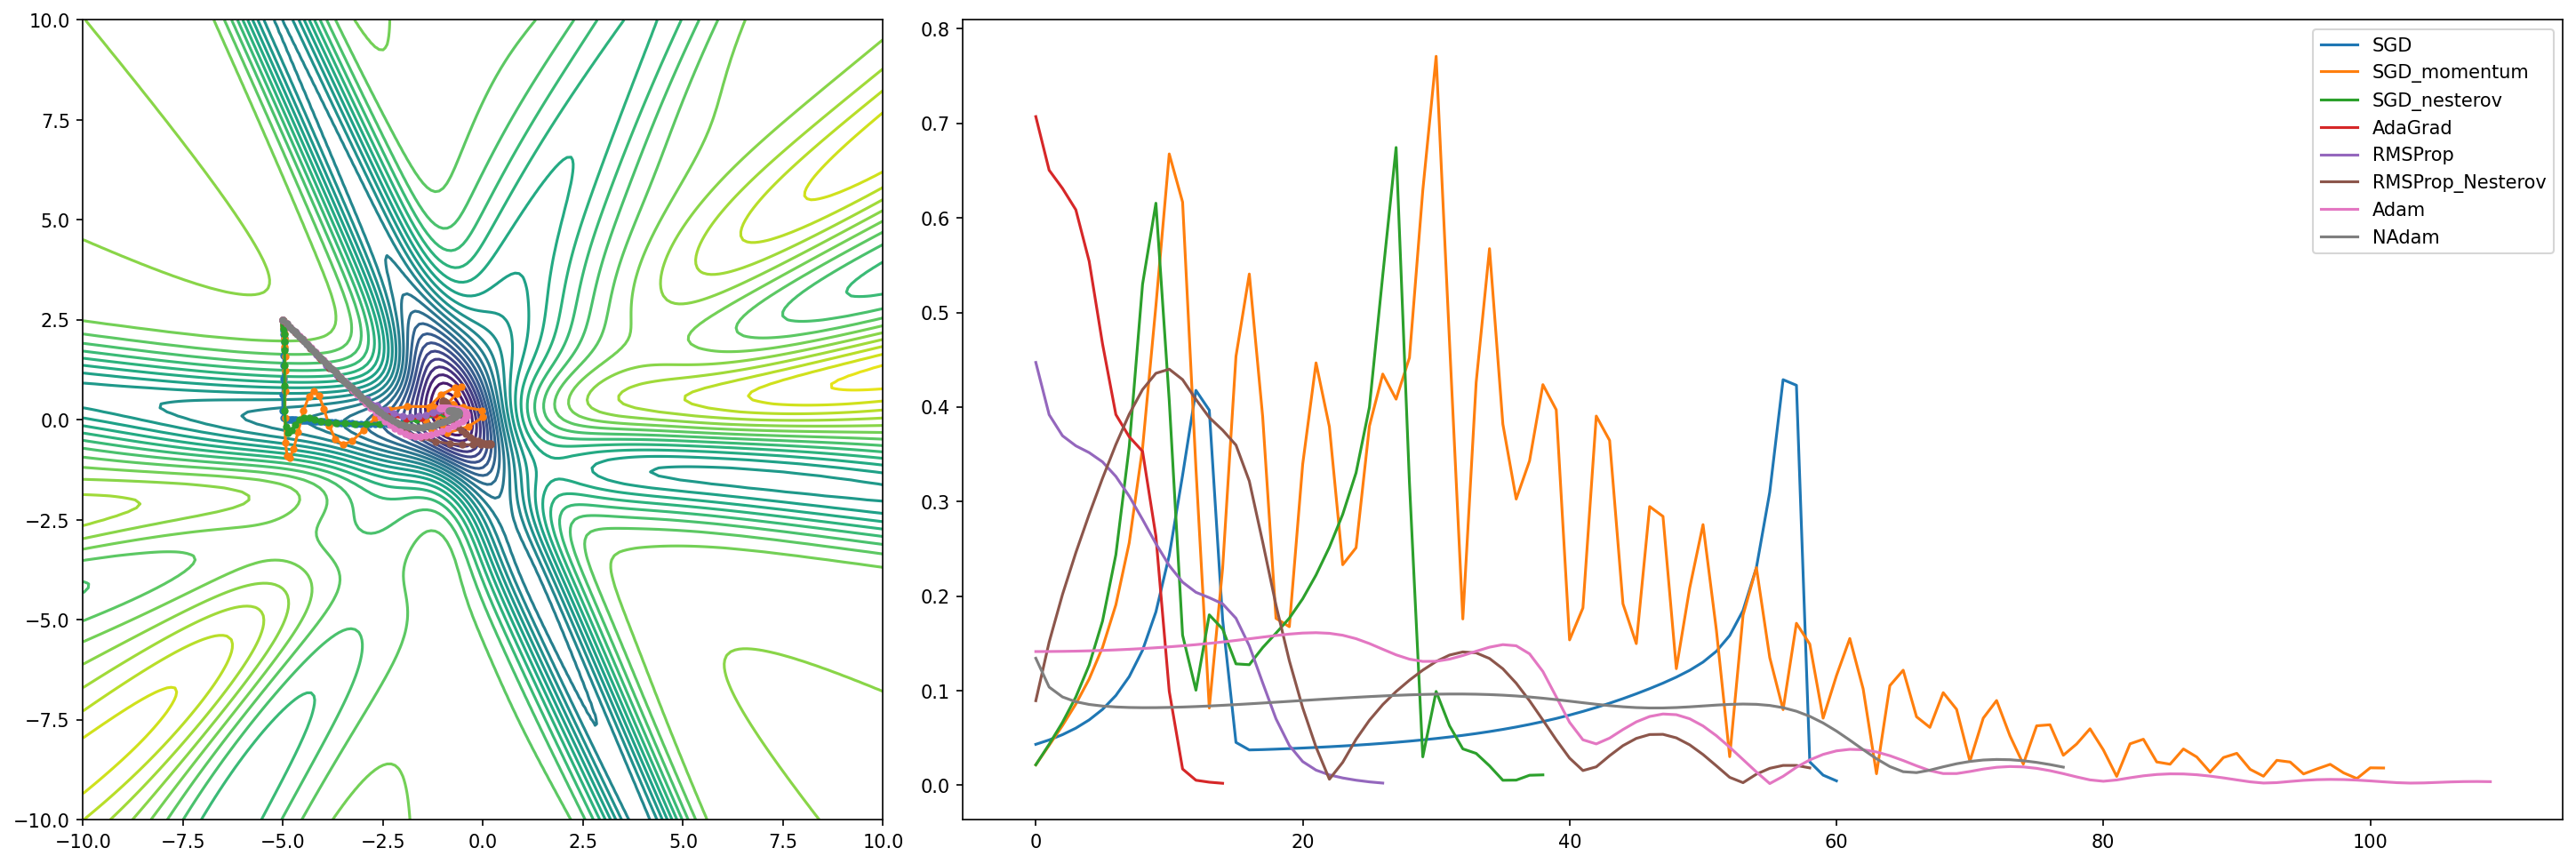

In [12]:
init_pos = np.array([-5,2.5])

# 2.5, 0 - saw divergence between SGD(ish) and others

data = {
    'SGD': SGD(L, G, init_pos, eps=1e-1),
    'SGD_momentum': SGD_momentum(L, G, init_pos, eps=5e-2),
    'SGD_nesterov': SGD_nesterov(L, G, init_pos, eps=5e-2),
    'AdaGrad': AdaGrad(L, G, init_pos, eps=5e-1),
    'RMSProp': RMSProp(L, G, init_pos, eps=1e-1),
    'RMSProp_Nesterov': RMSProp_nesterov(L, G, init_pos, eps=2e-2),
    'Adam': Adam(L, G, init_pos, eps=1e-1),
    'NAdam': NAdam(L, G, init_pos, eps=5e-2)
#    'AdamW': AdamW(L, G, init_pos, eps=1e-2, l=1e-1)
#    'Newton': Newton(L, G, H, init_pos)
}

fig = plt.figure(figsize=(12,6), dpi=150)

contour = fig.add_axes([0,0,0.5,1])
velocity = fig.add_axes([0.55,0,1,1])
# TODO scaling contour to region of interest?
CS = contour.contour(x, y, ll, 30)

for path in data:
    xp, yp = np.array(data[path][0][:200]).T
    contour.plot(xp, yp, marker='.', label=path)
    v = data[path][1]
    velocity.plot(v, label=path)

velocity.legend()

In [13]:
# with open("func.dill", "wb") as f:
#     dill.dump((L,G,H), f)

In [14]:
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# xp, yp = np.array(data['Adam'][0]).T
# contour = go.Contour(
#     z = ll,
#     x = x,
#     y = y
# )

# #path = go.Scatter(x=xp, y=yp)

# fig = make_subplots()
# fig.add_trace(contour)
# #fig.add_trace(path)
# fig['layout'].update(height = 600, width = 800, title = "Paths")

# fig.update(frames=[
#     go.Frame(
#         data=[
#             go.Contour(z = ll, x=x, y=y, visible=True),
#             go.Scatter(x=xp[:k], y=yp[:k], visible=True)
#         ]
#     )
#     for k in range(0, 100)]
# )

# fig.update_layout(
#     updatemenus=[
#         dict(
#             buttons=list([
#                 dict(label="Play",
#                         method="animate",
#                     args=[None, {"frame": {"duration": 100}}])
#             ]))])


# fig.show()

In [25]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as path_palette
from bokeh.palettes import Cividis256 as contour_palette
from bokeh.models import ColumnDataSource, Toggle, Slider, Button, BuiltinIcon, CustomJS
from bokeh.layouts import column, row
import itertools

In [30]:
output_notebook()

Loading BokehJS ...

In [19]:

p = figure(width=800, height=600, x_range=(-6, 1), y_range=(-2, 3))

all_data = {}
path_data = {}
paths = {}

for path in data:
    all_data[path] = {}
    all_data[path]['x'], all_data[path]['y'] = np.array(data[path][0]).T
    path_data[path] = ColumnDataSource(data=dict(x=all_data[path]['x'], y=all_data[path]['y']))

colors = itertools.cycle(path_palette)
levels = np.linspace(-13,2,30)
contour_renderer = p.contour(x, y, ll, levels, line_color=contour_palette, line_alpha=0.5)

labels = [p for p in all_data]

anim_callback = CustomJS(args=dict(all_data=all_data, path_data=path_data), code="""
    const f = cb_obj.value
    for (const path in path_data) {
        const x = all_data[path].x.slice(0,f+1)
        const y = all_data[path].y.slice(0,f+1)
        path_data[path].data = {x, y}
    }
""")
slider = Slider(start=0, end=100, value=0, step=1, title="Path")
slider.js_on_change("value", anim_callback)

for path in data:
    
    color = next(colors)
    paths[path] = p.line('x', 'y', source=path_data[path], legend_label=path, 
                         color=color, line_width=2, line_alpha=0.8,
                         muted_color=color, muted_alpha=0.1)

toggl_js = CustomJS(args=dict(slider=slider),code="""
    var check_and_iterate = function(n_steps){
        var slider_val = slider.value;
        var toggle_val = cb_obj.active;
        if(toggle_val == false) {
            cb_obj.label = '► Play';
            clearInterval(looop);
            } 
        else if(slider_val == n_steps) {
            cb_obj.label = '► Play';
            slider.value = 0;
            cb_obj.active = false;
            clearInterval(looop);
        }
        else if(slider_val !== n_steps){
            slider.value = slider.value + 1;
        }
        else {
            clearInterval(looop);
        }
    }
    if(cb_obj.active == false){
        cb_obj.label = '► Play';
        clearInterval(looop);
    }
    else {
        cb_obj.label = '❚❚ Pause';
        var looop = setInterval(check_and_iterate, 100, 100);
    };
""")

toggl = Toggle(label='► Play',active=False)
toggl.js_on_change('active',toggl_js)

colorbar = contour_renderer.construct_color_bar()
p.add_layout(colorbar, "right")
p.legend.click_policy = "mute"

full_plot = column(row(toggl, slider), p)

show(full_plot)


In [20]:
from bokeh.resources import CDN
from bokeh.resources import CDN
from bokeh.embed import file_html

plot_html = file_html(full_plot, CDN, 'intro_plot')
with open('intro_plot.html', 'w') as f:
    f.write(plot_html)

In [32]:
from bokeh.models import Arrow, VeeHead

# momentum plot
pt = (-2,1)
pt_g = G(pt)
a = 0.9
eps = 1e-2

p = figure(width=800, height=600, x_range=(-3, -1), y_range=(0, 2))

colors = itertools.cycle(path_palette)
levels = np.linspace(-13,2,30)
contour_renderer = p.contour(x, y, ll, levels, line_color=contour_palette, line_alpha=0.5)

p.add_layout(Arrow(end=VeeHead(size=10, fill_color="red", line_color="red"), line_color="red",
                   x_start=pt[0], y_start=pt[1], x_end=pt[0]-eps*pt_g[0], y_end=pt[1]-eps*pt_g[1]))
show(p)